In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/Supply-Chain-Forecast-main/Supply-Chain-Forecast-main/Data/df_time_series.xlsx"

In [5]:
# Cargar desde Excel
df = pd.read_excel(path)

# Asegurarse de que la columna de fecha esté en formato datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])
df.set_index('FECHA', inplace=True)

# Variables objetivo
target_columns = ['CLORURO DE SODIO', 'LACTATO DE SODIO', 'METAMIZOL', 'PARACETAMOL', 'PROPOFOL']

# Crear lags
n_lags = 3
for col in target_columns:
    for lag in range(1, n_lags + 1):
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

# Eliminar filas con NaN
df.dropna(inplace=True)

# Separar entrada y salida
X = df[[col for col in df.columns if '_lag_' in col]]
y = df[target_columns]

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [6]:
model_svm = MultiOutputRegressor(SVR(kernel='rbf', C=100, epsilon=0.1))
model_svm.fit(X_train, y_train)

# Predecir
y_pred = model_svm.predict(X_test)


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

metrics = []
for i, col in enumerate(target_columns):
    y_t = y_test.iloc[:, i]
    y_p = y_pred[:, i]

    metrics.append({
        'Variable': col,
        'MAE': mean_absolute_error(y_t, y_p),
        'RMSE': np.sqrt(mean_squared_error(y_t, y_p)),
        'R2': r2_score(y_t, y_p),
        'MAPE (%)': mean_absolute_percentage_error(y_t, y_p)
    })

metrics_df = pd.DataFrame(metrics).set_index('Variable')
print(metrics_df.round(2))


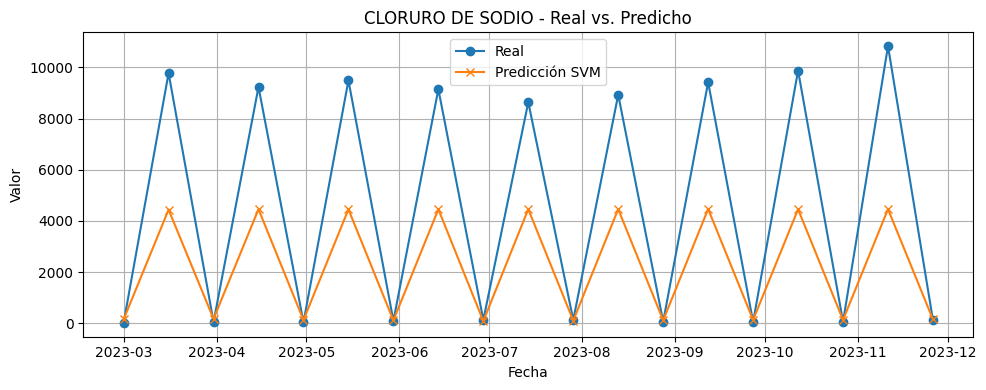

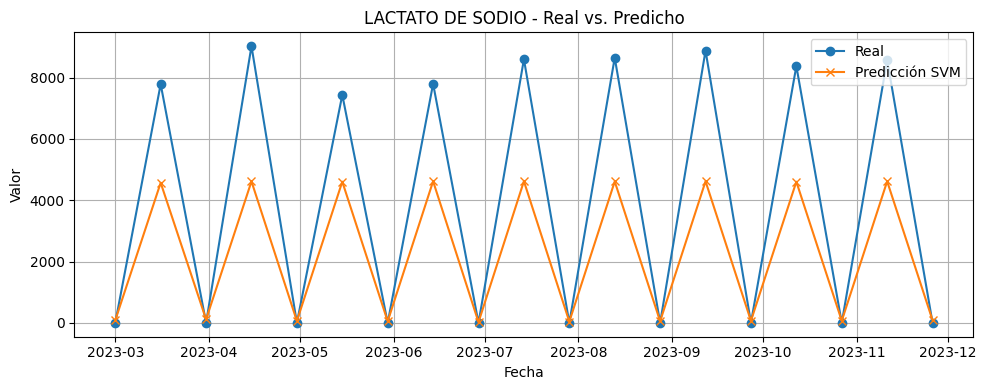

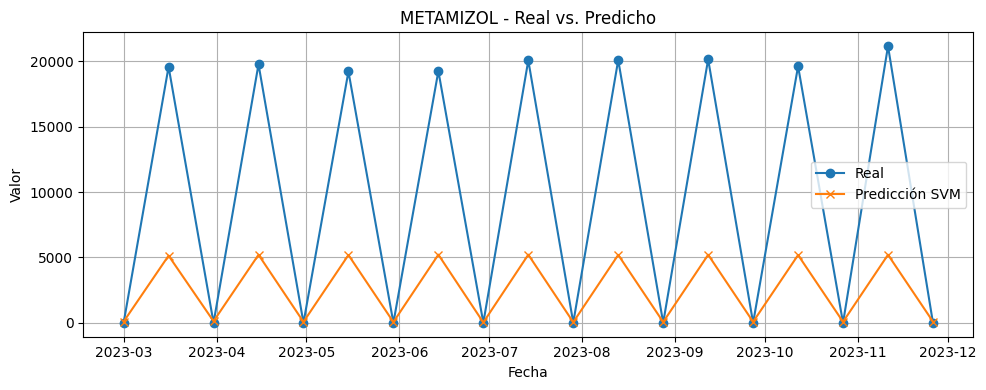

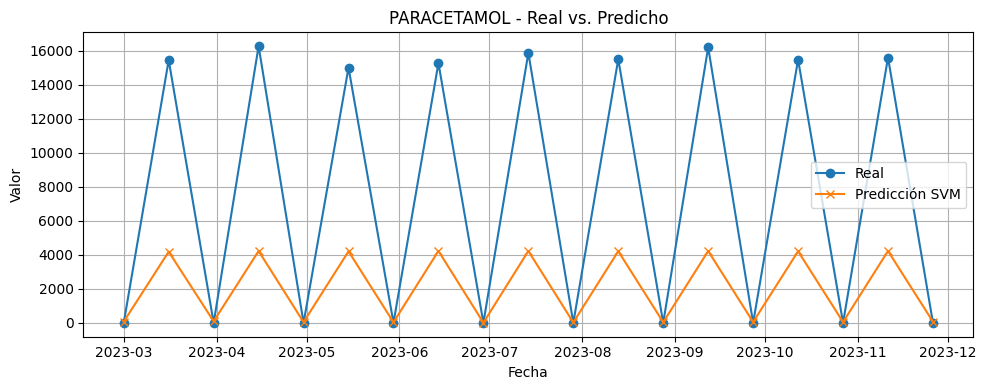

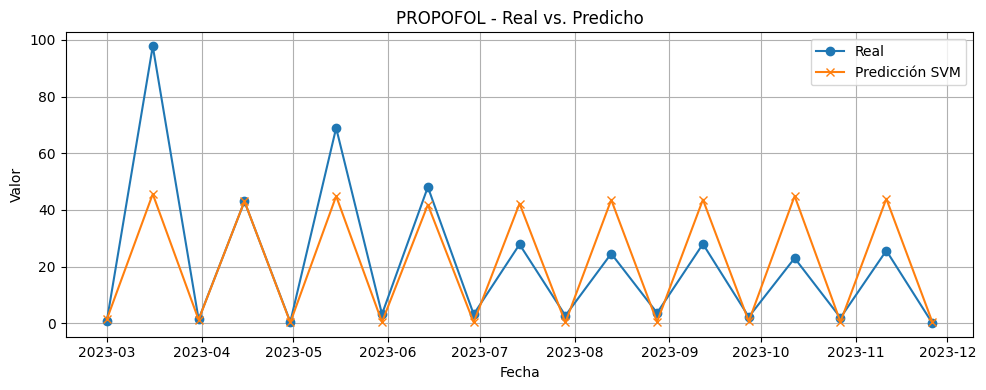

In [7]:
import matplotlib.pyplot as plt

# Asegura que las fechas de test estén disponibles
fechas_test = y_test.index

for i, col in enumerate(target_columns):
    plt.figure(figsize=(10, 4))
    plt.plot(fechas_test, y_test.iloc[:, i], label='Real', marker='o')
    plt.plot(fechas_test, y_pred[:, i], label='Predicción SVM', marker='x')
    plt.title(f'{col} - Real vs. Predicho')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
import numpy as np

n_future = 4  # días a predecir
last_known = df.copy()  # copia con últimos valores disponibles

predictions = []

for _ in range(n_future):
    # Crear la fila de entrada para el próximo día
    last_input = []

    for col in target_columns:
        # Tomar los últimos 'n_lags' valores conocidos o predichos
        vals = last_known[col].values[-n_lags:]
        last_input.extend(vals[::-1])  # invertir para que lag_1 sea el más reciente

    # Convertir a array 2D para el modelo
    input_array = np.array(last_input).reshape(1, -1)

    # Predecir siguiente día
    next_pred = model_svm.predict(input_array)[0]  # array de 5 valores
    predictions.append(next_pred)

    # Crear un nuevo registro con las predicciones
    new_row = dict(zip(target_columns, next_pred))
    for col in target_columns:
        for lag in range(1, n_lags + 1):
            new_row[f'{col}_lag_{lag}'] = last_known[col].values[-lag]

    # Agregar la predicción a last_known para usarla en el siguiente ciclo
    last_known = pd.concat([last_known, pd.DataFrame([new_row])], ignore_index=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

In [16]:
future_df = pd.DataFrame(predictions, columns=target_columns)
future_df.index.name = 'Periodo'
print(future_df)

         CLORURO DE SODIO  LACTATO DE SODIO    METAMIZOL  PARACETAMOL  \
Periodo                                                                 
0             4447.596742       4592.480037  5170.860436  4209.355103   
1              707.988285        749.053613   933.747938   655.015081   
2             3034.665127       3352.091412  4005.370635  3058.799337   
3             1617.629277       1830.041817  2297.911213  1661.019376   

          PROPOFOL  
Periodo             
0        45.508616  
1         3.468758  
2        11.261050  
3         0.396272  


In [17]:
from datetime import timedelta

n_future = len(future_df)  # ya definido antes
future_dates = pd.date_range(start=last_date + timedelta(days=15),
                             periods=n_future, freq='15D')

# Asignar al DataFrame de predicciones
future_df['FECHA'] = future_dates
future_df.set_index('FECHA', inplace=True)

In [18]:
# Última fecha del dataset
last_date = df.index.max()

In [19]:
from datetime import timedelta

n_future = len(future_df)  # ya definido antes
future_dates = pd.date_range(start=last_date + timedelta(days=15),
                             periods=n_future, freq='15D')

# Asignar al DataFrame de predicciones
future_df['FECHA'] = future_dates
future_df.set_index('FECHA', inplace=True)

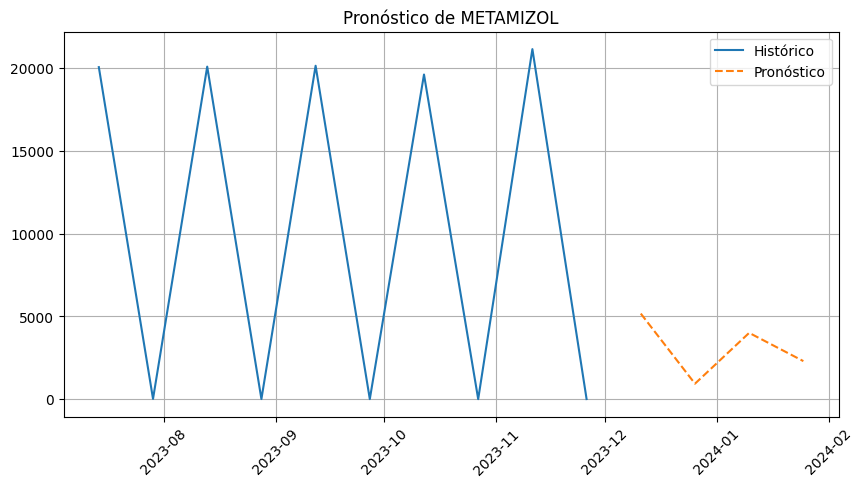

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(df.index[-10:], df['METAMIZOL'].iloc[-10:], label='Histórico')
plt.plot(future_df.index, future_df['METAMIZOL'], label='Pronóstico', linestyle='--')
plt.title('Pronóstico de METAMIZOL')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, max_error, explained_variance_score

import numpy as np
import pandas as pd

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

In [24]:
metrics = []

for i, col in enumerate(target_columns):
    y_true = y_test.iloc[:, i].values
    y_hat = y_pred[:, i]

    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_hat)
    mape = mean_absolute_percentage_error(y_true, y_hat)
    r2 = r2_score(y_true, y_hat)
    medae = median_absolute_error(y_true, y_hat)
    maxerr = max_error(y_true, y_hat)
    evs = explained_variance_score(y_true, y_hat)

    metrics.append({
        'Variable': col,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'R²': r2,
        'MedAE': medae,
        'MaxError': maxerr,
        'Explained Variance': evs
    })


In [27]:
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Variable', inplace=True)
print(metrics_df.round(15))

                           MSE          RMSE          MAE      MAPE (%)  \
Variable                                                                  
CLORURO DE SODIO  1.214529e+07   3485.009219  2416.502391  1.263984e+02   
LACTATO DE SODIO  6.746602e+06   2597.422089  1805.320904  3.083565e+11   
METAMIZOL         1.022376e+08  10111.259432  6992.273992  9.297523e+10   
PARACETAMOL       6.169934e+07   7854.892588  5427.802163  2.037625e+11   
PROPOFOL          2.632508e+02     16.225004     9.853965  6.904798e+01   

                        R²       MedAE      MaxError  Explained Variance  
Variable                                                                  
CLORURO DE SODIO  0.453944  135.281426   6371.504557            0.702985  
LACTATO DE SODIO  0.614627  112.983790   4410.917385            0.786896  
METAMIZOL        -0.036801  121.556266  15946.423497            0.448235  
PARACETAMOL      -0.013007   90.275684  12037.638816            0.461871  
PROPOFOL          0.6199